<a href="https://colab.research.google.com/github/mustafaerdikararmaz/BICE/blob/main/bice_ex_week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5: Biological Neuron Models, SNNs & RNNs
## The biological edge
After achieving state of the art performance on MNIST, Charlemagne's team is sure that you have solved vanilla machine learning. It is time for greener pastures! To really have a competitive edge in the market, we will go back to the biological roots - because as our historians know, the co-development between neuroscience and machine learning is well documented in its achievements.

In this exercise, we will take a look at some more realistic empirical neuron models and their dynamics before moving on to how we might implement these biological components in a computationally efficient manner for our models.

## Part 1: Biological Point Neurons (6 points)
In the lectures, the Hodgkin-Huxley model was defined by the following set of differential equations:

\begin{equation*}
  \begin{aligned}
    C\dot{V}&=I - \bar{g}_{\text{K}^+} n^4 (V-E_{\text{K}^+})
                - \bar{g}_{\text{Na}^+} m^3 h (V-E_{\text{Na}^+})
                - g_\text{L} (V-E_{\text{L}})\\
    \dot{n}&=\left(n_\infty(V)-n\right)/\tau_n(V) \hspace{10cm} \\
    \dot{m}&=\left(m_\infty(V)-m\right)/\tau_m(V)\\
    \dot{h}&=\left(h_\infty(V)-h\right)/\tau_h(V)
  \end{aligned}
\end{equation*}

It is convenient to rewrite the last three equations in the form

\begin{equation}
  \dot{x}=\alpha_x(V)(1-x)-\beta_x(V){}x
  \quad\text{(with $x\in\{n,m,h\}$)}. \hspace{5cm}
\end{equation}

The coefficients $\alpha_x(V)$ and $\beta_x(V)$ represent the
(voltage-dependent) activation and inactivation rates, respectively,
for the gate $x$. With these coefficients, the steady-state activation
variables $x_\infty(V)$ and the time constants $\tau_x(V)$ in
(12.1) are given by

\begin{equation}
    x_\infty(V) = \frac{\alpha_x(V)}{\alpha_x(V)+\beta_x(V)}
    \qquad\text{and}\qquad
    \tau_x(V)   = \frac{1}{\alpha_x(V) + \beta_x(V)}. \hspace{2cm}
\end{equation}

### Exercise 1.1: Hodgkin-Huxley Forward Euler Implementation (2 points)
We now want to simulate dynamics for a single HH neuron. Since we are dealing with a system of non-linear ODEs, we cannot solve this analytically. A simple but common way to integrate numerically is **Forward Euler**. It assumes a constant rate of change over the time-step $dt$:

\begin{equation}
    y_{n+1} = y_{n}+\frac{dy}{dt}\cdot dt
\end{equation}

This is a rather strong simplification and only works as long as $dt$ is very small because the main error term per step is quadratic $O(dt^2)$, but good enough to capture the dynamics we are interested in.


Below you'll find some scaffolding for a manual NumPy implementation of the basic Hodgkin-Huxley model. $\alpha_x(V)$ and $\beta_x(V)$ are given for all channels since they are based on empirical measurements. Complete the equations below the `TODO` comments!

**Note**: Please include your cell output for the plots in your hand-in after implementing a solution!

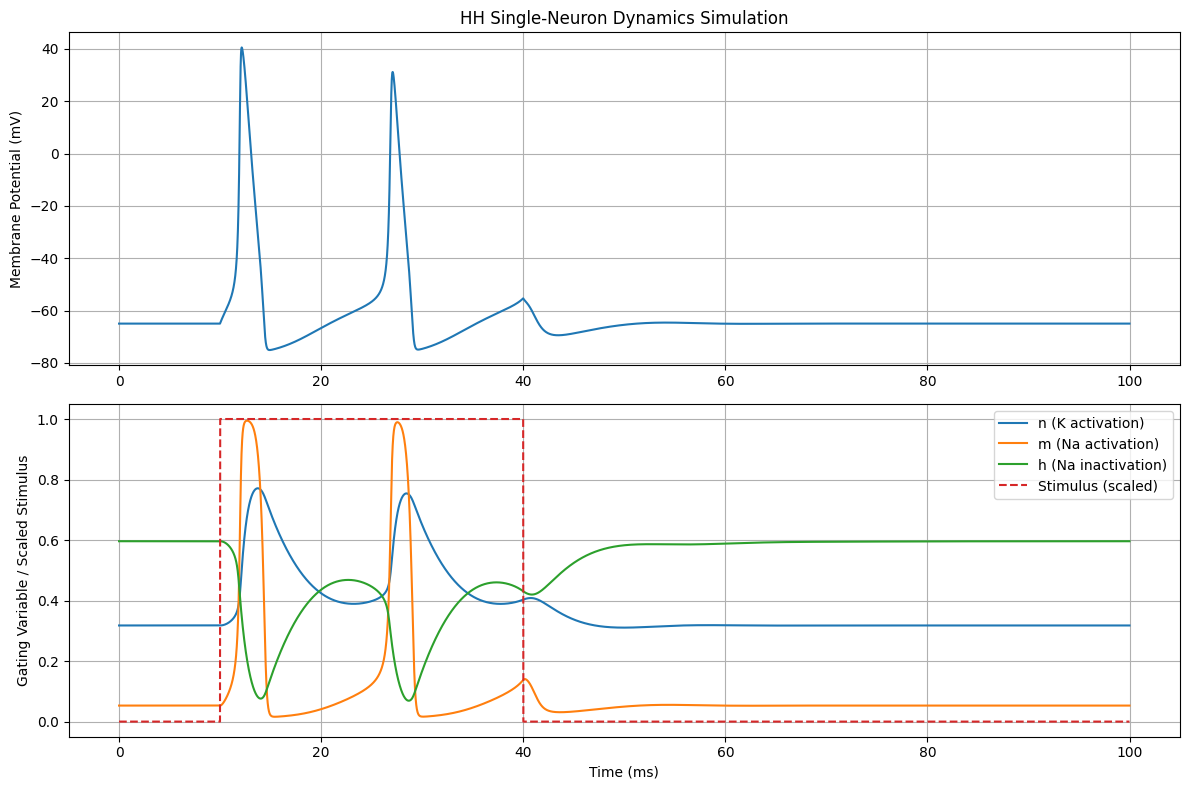

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# --- Hodgkin-Huxley Model Parameters ---

C_m = 1.0  # Membrane capacitance (uF/cm^2)
V_rest = -65.0  # Resting potential (mV)

# Derived from Nernst equation with empirical measurements from squid axon
E_Na = 50.0  # Sodium reversal potential (mV)
E_K = -77.0  # Potassium reversal potential (mV)
E_L = -54.4  # Leak reversal potential (mV)

g_Na = 120.0  # Maximum sodium conductance (mS/cm^2)
g_K = 36.0  # Maximum potassium conductance (mS/cm^2)
g_L = 0.3  # Leak conductance (mS/cm^2)


# --- Voltage-dependent rate functions (alpha and beta) ---
# Careful! We always want to use voltage relative to the resting potential here


def alpha_n(V_abs):
    V_rel = V_abs - V_rest
    if V_rel == 10.0:  # L'Hopital
        return 0.1  # Limit of 0.01 * x / (exp(x/10)-1) as x->0 is 0.01*10 = 0.1
    return 0.01 * (10.0 - V_rel) / (np.exp((10.0 - V_rel) / 10.0) - 1.0)


def beta_n(V_abs):
    V_rel = V_abs - V_rest
    return 0.125 * np.exp(-V_rel / 80.0)


def alpha_m(V_abs):
    V_rel = V_abs - V_rest
    if V_rel == -25.0:  # L'Hopital
        return 1.0  # Limit of 0.1 * x / (exp(x/10)-1) as x->0 is 0.1*10 = 1.0
    return 0.1 * (25.0 - V_rel) / (np.exp((25.0 - V_rel) / 10.0) - 1.0)


def beta_m(V_abs):
    V_rel = V_abs - V_rest
    return 4.0 * np.exp(-V_rel / 18.0)


def alpha_h(V_abs):
    V_rel = V_abs - V_rest
    return 0.07 * np.exp(-V_rel / 20.0)


def beta_h(V_abs):
    V_rel = V_abs - V_rest
    return 1.0 / (np.exp((30.0 - V_rel) / 10.0) + 1.0)


# --- Differential Equations ---

def dVdt(V, n, m, h, I_ext):
    # TODO: Implement dV/dt

    I_K = g_K * n**4 * (V - E_K)
    I_Na = g_Na * m**3 * h * (V - E_Na)
    I_L = g_L * (V - E_L)
    dV = (I_ext - I_K - I_Na - I_L) / C_m

    return dV


def dndt(V, n):
    # TODO: Implement x' for the potassium activation channel (n)
    Tau_n = 1/(alpha_n(V) + beta_n(V))
    n_inf = alpha_n(V)/(alpha_n(V) + beta_n(V))
    return (n_inf - n)/Tau_n


def dmdt(V, m):
    # TODO: Implement x' for the sodium activation channel (m)
    Tau_m = 1/(alpha_m(V) + beta_m(V))
    m_inf = alpha_m(V)/(alpha_m(V) + beta_m(V))
    return (m_inf - m)/Tau_m


def dhdt(V, h):
    # TODO: Implement x' for the sodium inactivation channel (h)
    Tau_h = 1/(alpha_h(V) + beta_h(V))
    h_inf = alpha_h(V)/(alpha_h(V) + beta_h(V))
    return (h_inf - h)/Tau_h


def simulate_hh(sim_time, dt, I_ext):
    steps = int(sim_time / dt)

    if len(I_ext) != steps:
        raise ValueError(f"I_ext_arr must have length equal to sim_time / dt ({steps})")

    V_m = V_rest

    # Calculate initial gating values at V_rest using steady-state formulas
    n = alpha_n(V_m) / (alpha_n(V_m) + beta_n(V_m))
    m = alpha_m(V_m) / (alpha_m(V_m) + beta_m(V_m))
    h = alpha_h(V_m) / (alpha_h(V_m) + beta_h(V_m))

    # Store traces for later plotting
    V_trace = np.zeros(steps)
    n_trace = np.zeros(steps)
    m_trace = np.zeros(steps)
    h_trace = np.zeros(steps)

    V_trace[0] = V_m
    n_trace[0] = n
    m_trace[0] = m
    h_trace[0] = h

    # --- Simulation Loop (Forward Euler Method) ---
    for i in range(1, steps):
        current_V = V_trace[i - 1]
        current_n = n_trace[i - 1]
        current_m = m_trace[i - 1]
        current_h = h_trace[i - 1]
        current_I_ext = I_ext[i]

        dV = dVdt(current_V, current_n, current_m, current_h, current_I_ext)
        dn = dndt(current_V, current_n)
        dm = dmdt(current_V, current_m)
        dh = dhdt(current_V, current_h)

        # TODO: Evaluate derivative for current step and then update V, n, m, h (stored in traces) using Euler method
        V_trace[i] = current_V + dV * dt
        n_trace[i] = current_n + dn * dt
        m_trace[i] = current_m + dm * dt
        h_trace[i] = current_h + dh * dt

    return V_trace, n_trace, m_trace, h_trace


def plot_hh(sim_time, dt, v_hist, n_hist, m_hist, h_hist, I_ext):
    time_arr = np.arange(0, sim_time, dt)
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_arr, v_hist)
    plt.ylabel("Membrane Potential (mV)")
    plt.title("HH Single-Neuron Dynamics Simulation")
    plt.grid(True)

    # Scale to show channel conductance properly
    max_I_ext = np.max(np.abs(I_ext))
    if max_I_ext == 0:
        max_I_ext = 1.0

    plt.subplot(2, 1, 2)
    plt.plot(time_arr, n_hist, label='n (K activation)')
    plt.plot(time_arr, m_hist, label='m (Na activation)')
    plt.plot(time_arr, h_hist, label='h (Na inactivation)')
    plt.plot(time_arr, I_ext / max_I_ext, '--', label='Stimulus (scaled)')

    plt.ylabel("Gating Variable / Scaled Stimulus")
    plt.xlabel("Time (ms)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


sim_duration = 100.0  # Total simulation time (ms)
time_step = 0.01  # Time step (ms) This cannot be any larger or Euler will collapse!
num_steps = int(sim_duration / time_step)

ext_current = np.zeros(num_steps)

# Example 1: A single square pulse
pulse_start_time = 10.0
pulse_end_time = 40.0
pulse_amplitude = 10.0  # uA/cm^2

pulse_start_step = int(pulse_start_time / time_step)
pulse_end_step = int(pulse_end_time / time_step)
ext_current[pulse_start_step:pulse_end_step] = pulse_amplitude

# Run & plot
voltage_trace, n_trace, m_trace, h_trace = simulate_hh(sim_duration, time_step, ext_current)
plot_hh(sim_duration, time_step, voltage_trace, n_trace, m_trace, h_trace, ext_current)


We expect the result to look like:
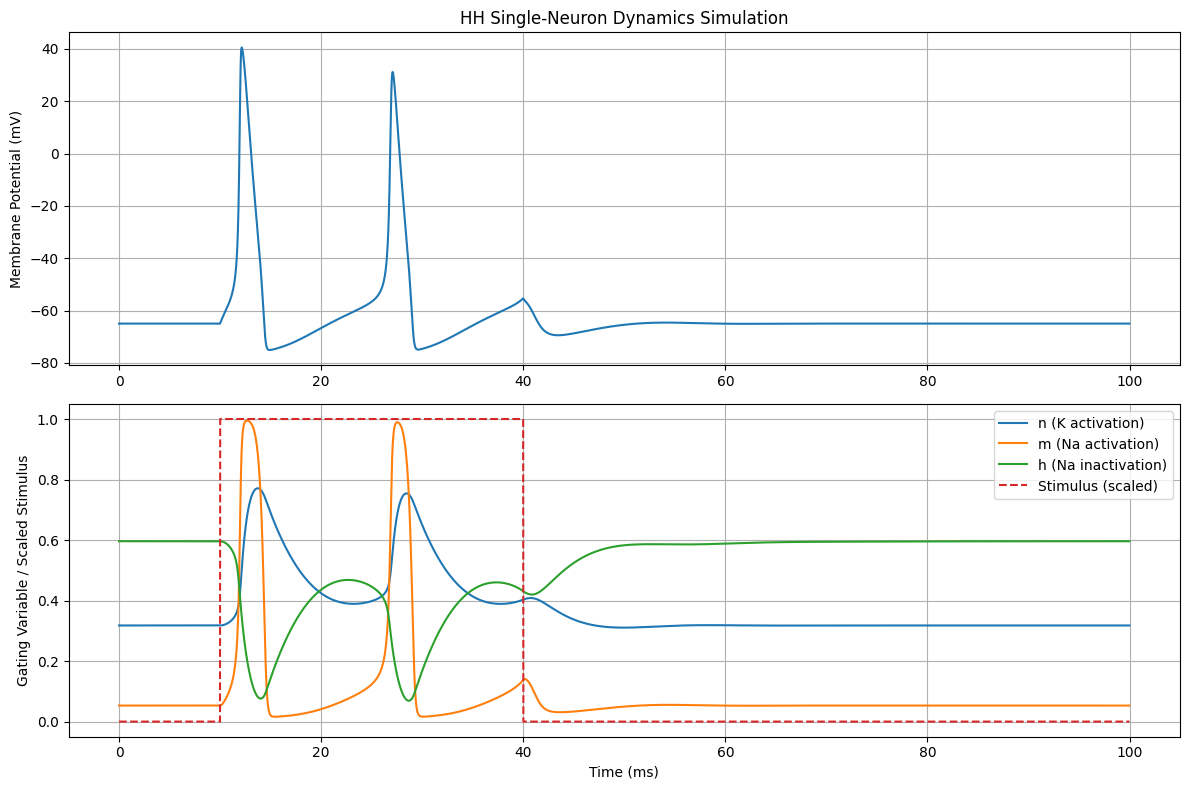

### Exercise 1.2: Single Neuron Dynamics (2 points)
Now that we have a simulation setup, we can manipulate the external current applied to observe various responses characteristic of more complex neuron models. Tweak the stimuli and give your answers to the questions below, either by directly editing the cell to include an answer or in an auxiliary document if you prefer. You can use the cells below to prototype your answer.

- For a stimuli period of 1ms, empirically find what one might consider the spike threshold, aka the minimum amplitude necessary to elicit a sharp rise of membrane potential into positive values from resting potential. What happens if you change the stimuli period?

*For the stimuli period of 1ms(1ms step function and the resting is 0), 6.976V is enough to bring the membrane potential to the positive values. If we increase the stimuli period (for example for 2 ms), the membrane potential will be increased(first one was around 20mV but the second one was around 40mV.) In addition to that, the spike latency reduced(the spike occured sooner than the first one.)*

- Setup two 1ms pulses of an arbitrary value above threshold, separated by 1-2ms. Why doesn’t this second pulse cause a second spike? Phrase your answer in
terms of gates and voltages. Consider the plot of $n$, $m$ and $h$ below
the voltage.

*The reason for that is refractory period. The h channel is still low(Na channels closed) and n channel still high(meaning that K channels are still open and flowing) causing this refractory period. This causes the second pulse does not spike at all.*

- Refer to the diagram of different firing patterns below. A wide variety of the patterns is supported by HH. Pick three of them and reproduce typical behaviour in the code cell(s) below! Use the plot to verify.

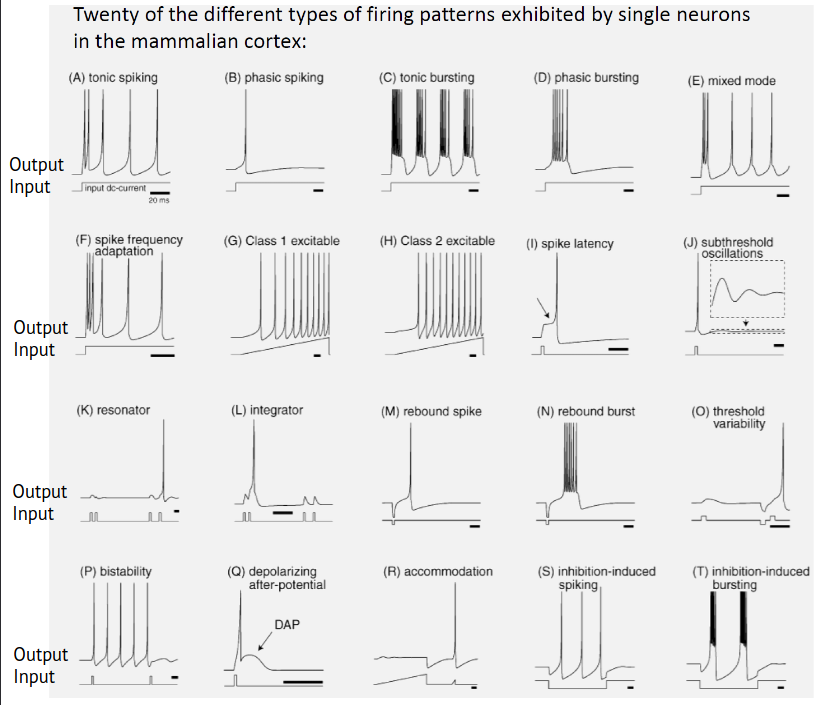

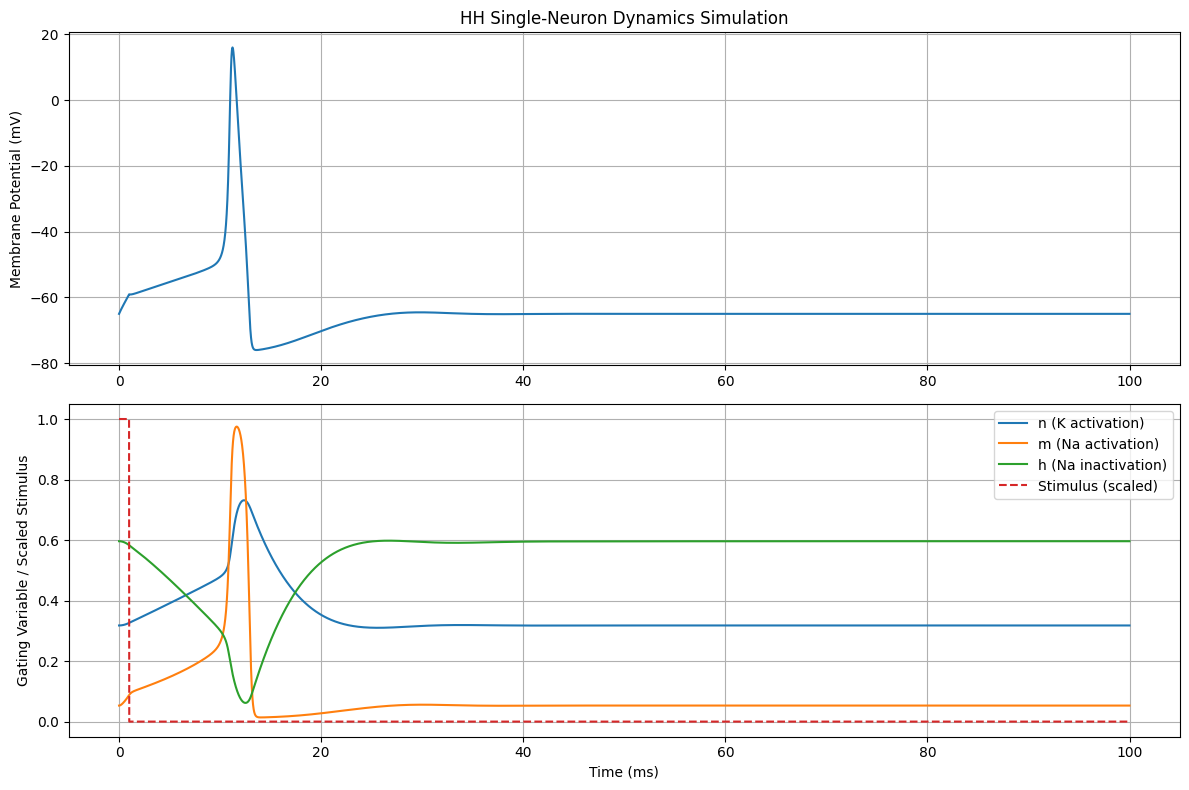

In [34]:
# TODO: Implement your solutions in this cell, clone it if necessary

sim_duration = 100.0 #(ms)  # Total simulation time (ms)
time_step = 0.01  # Time step (ms) This cannot be any larger or Euler will collapse!
num_steps = int(sim_duration / time_step)
_1ms = int(num_steps/100)

ext_current = np.zeros(num_steps)
# create 1 ms periodic steps
ext_current[0:_1ms] = 6.976
#ext_current[0:2*_1ms] = 6.976 # for longer period

# Run & plot
voltage_trace, n_trace, m_trace, h_trace = simulate_hh(sim_duration, time_step, ext_current)
plot_hh(sim_duration, time_step, voltage_trace, n_trace, m_trace, h_trace, ext_current)



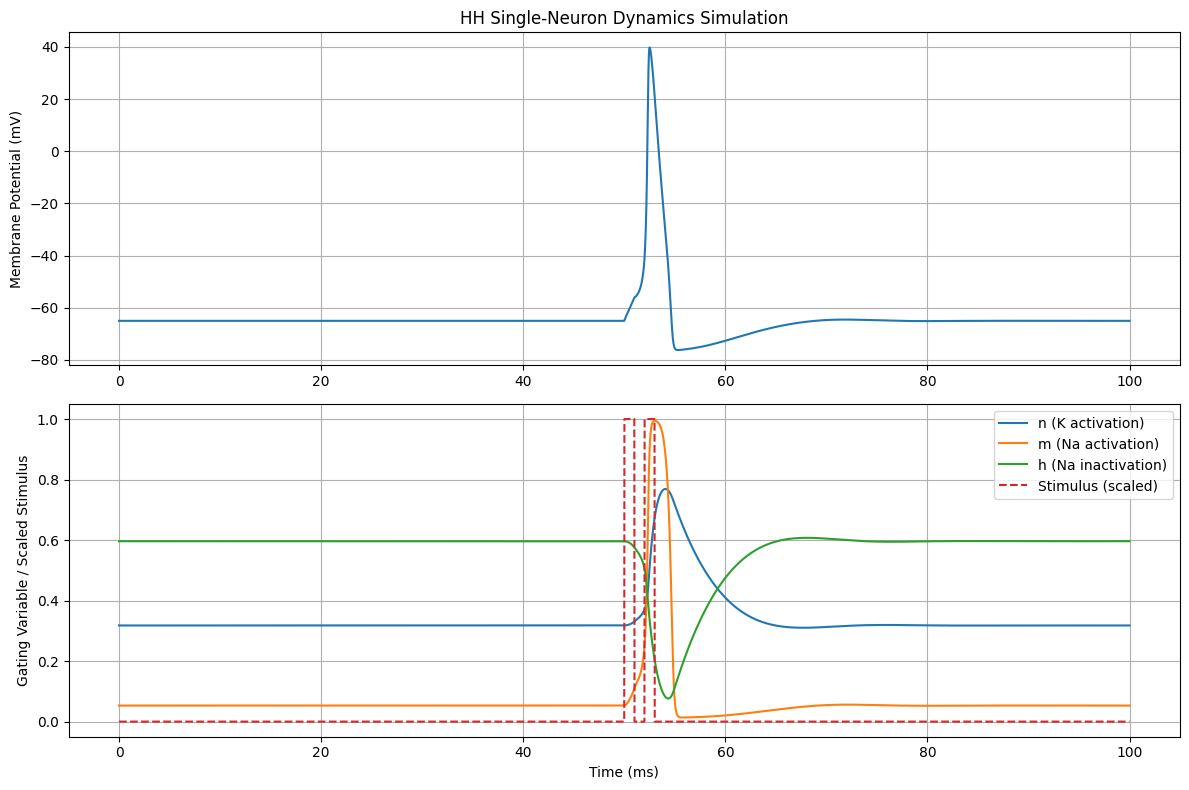

In [35]:
# TODO: Implement your solutions in this cell, clone it if necessary

ext_current = np.zeros(num_steps)
ext_current[50*_1ms:51*_1ms] = 10 #pulse in 50th ms
ext_current[52*_1ms:53*_1ms] = 10 #pulse in 52nd ms

# Run & plot
voltage_trace, n_trace, m_trace, h_trace = simulate_hh(sim_duration, time_step, ext_current)
plot_hh(sim_duration, time_step, voltage_trace, n_trace, m_trace, h_trace, ext_current)

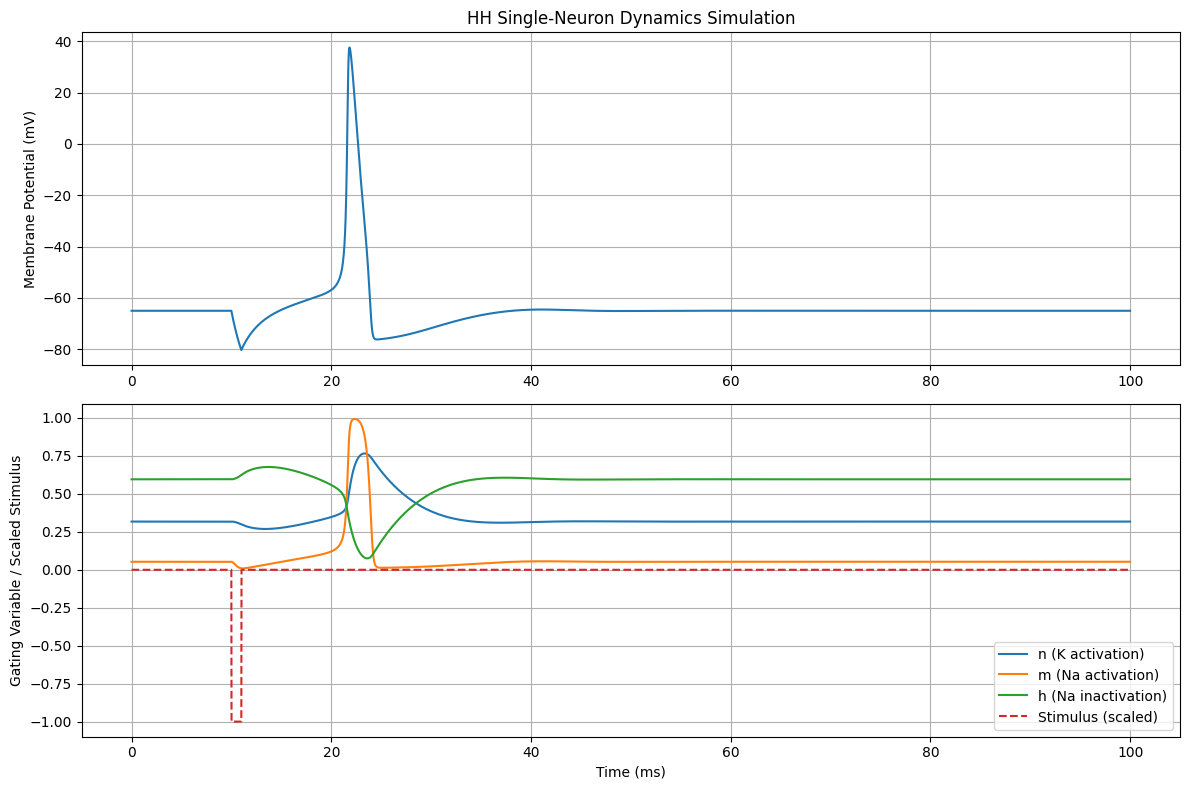

In [41]:
# TODO: Implement your solutions in this cell, clone it if necessary

# M) rebound spike

ext_current = np.zeros(num_steps)
ext_current[10*_1ms:11*_1ms] = -20

# Run & plot
voltage_trace, n_trace, m_trace, h_trace = simulate_hh(sim_duration, time_step, ext_current)
plot_hh(sim_duration, time_step, voltage_trace, n_trace, m_trace, h_trace, ext_current)

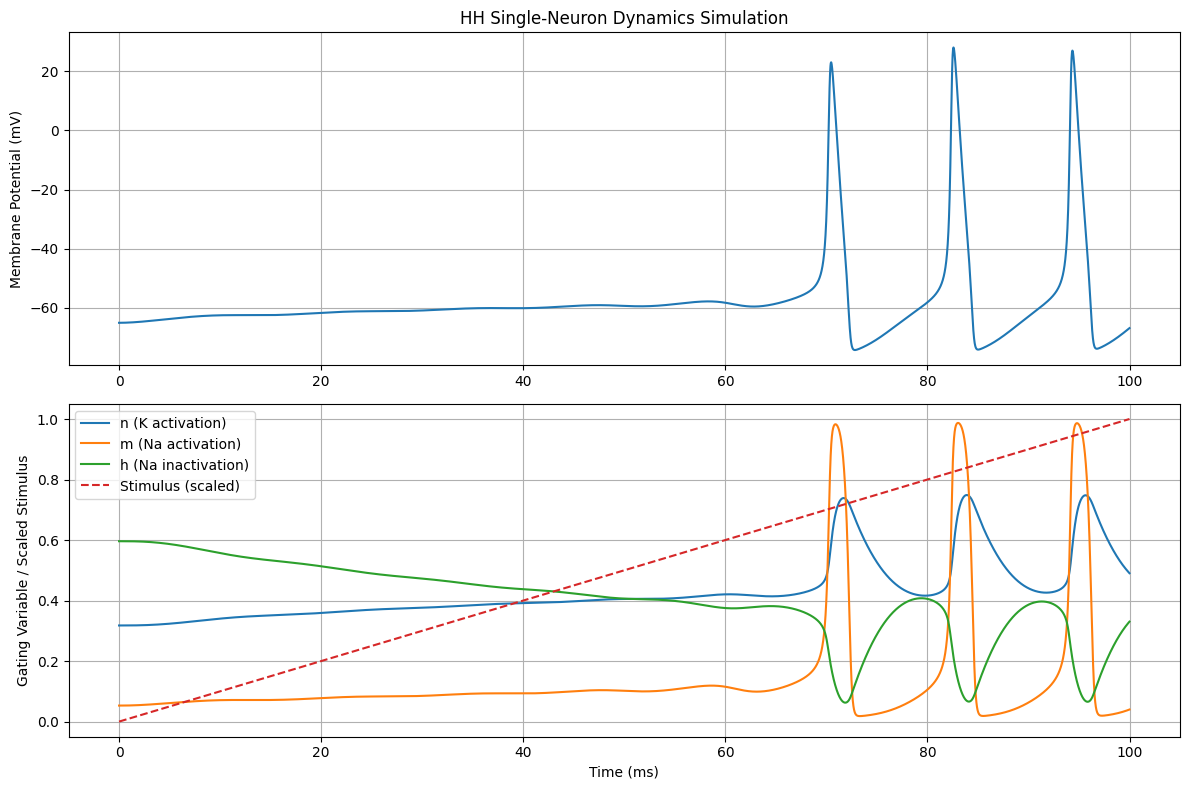

In [47]:
# TODO: Implement your solutions in this cell, clone it if necessary

# H) class 2 excitable

ext_current = np.linspace(0,20,num_steps)

# Run & plot
voltage_trace, n_trace, m_trace, h_trace = simulate_hh(sim_duration, time_step, ext_current)
plot_hh(sim_duration, time_step, voltage_trace, n_trace, m_trace, h_trace, ext_current)

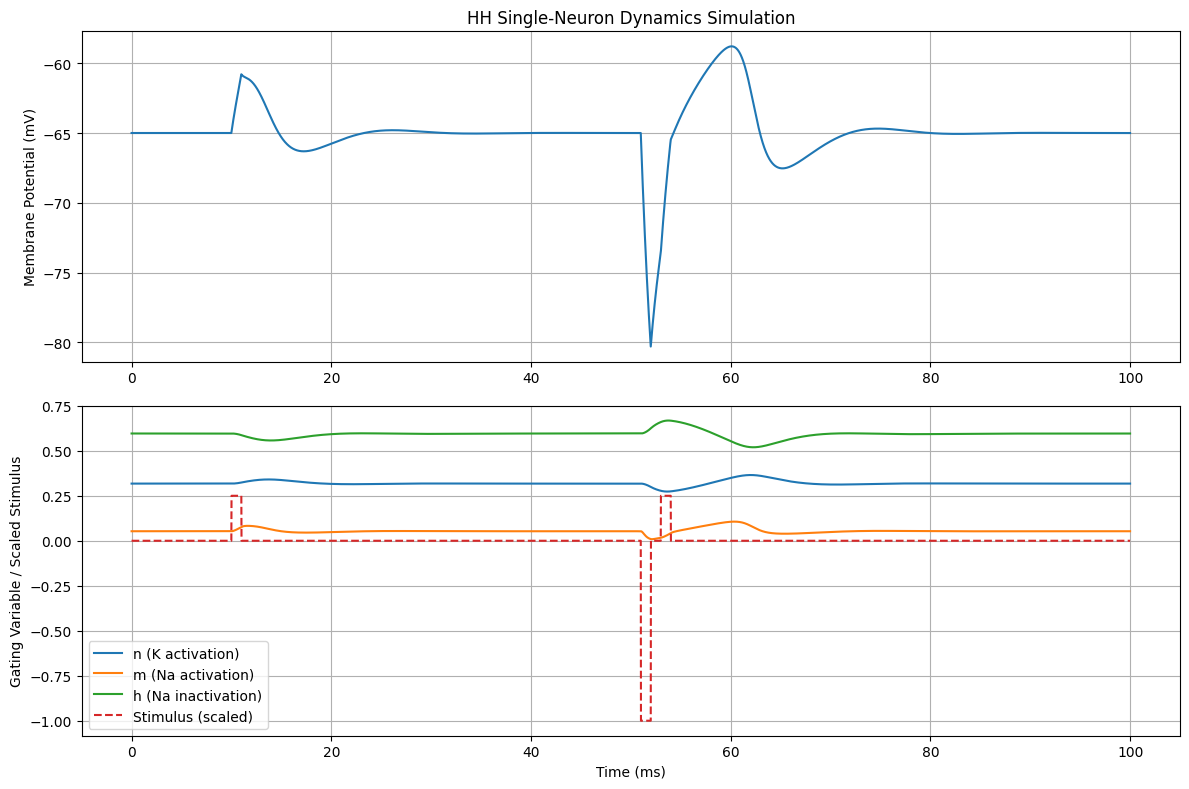

In [56]:
# TODO: Implement your solutions in this cell, clone it if necessary

# this is an interesting one, please do not count it as a solution.
# the neuron does not fire after the positive input but it should fire if there is not a positive input(due to the high negative input.)
ext_current = np.zeros(num_steps)
ext_current[10*_1ms:11*_1ms] = 5
ext_current[51*_1ms:52*_1ms] = -20
ext_current[53*_1ms:54*_1ms] = 5


# Run & plot
voltage_trace, n_trace, m_trace, h_trace = simulate_hh(sim_duration, time_step, ext_current)
plot_hh(sim_duration, time_step, voltage_trace, n_trace, m_trace, h_trace, ext_current)

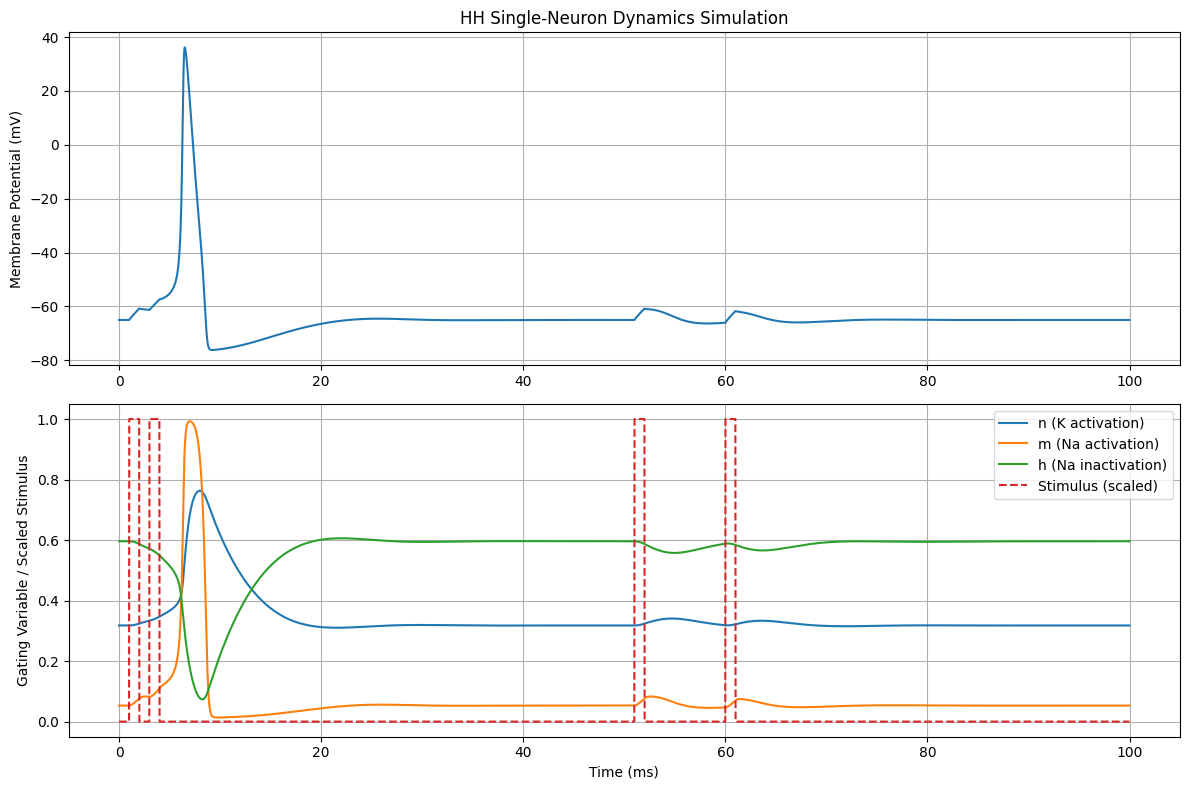

In [60]:
# TODO: Implement your solutions in this cell, clone it if necessary

# L) integrator

ext_current = np.zeros(num_steps)
ext_current[1*_1ms:2*_1ms] = 5
ext_current[3*_1ms:4*_1ms] = 5

ext_current[51*_1ms:52*_1ms] = 5
ext_current[60*_1ms:61*_1ms] = 5

# Run & plot
voltage_trace, n_trace, m_trace, h_trace = simulate_hh(sim_duration, time_step, ext_current)
plot_hh(sim_duration, time_step, voltage_trace, n_trace, m_trace, h_trace, ext_current)

### Exercise 1.3: (A)LIF Neurons: Biology Distilled (2 points)
The Hodgkin-Huxley model is a great pick when it comes to capturing biological detail, but when we are talking about spiking networks in machine learning or neuroscience simulations of large network, accurately solving multiple ODEs every timestep becomes computationally infeasible.


That's where the LIF model comes in, which implements the minimal mechanisms necessary to capture neural dynamics: subthreshold leakage, a refractory period and an all-or-nothing spike. We will implement this as:


\begin{equation*}
  \begin{aligned}
\tau_m \dot{V_m} &= -(V_m - E_{\text{rest}}) + R_m \cdot I_{\text{ext}}(t) \\
  \end{aligned}
\end{equation*}

where a spike is emitted by setting the membrane potential to $V_{reset}$ if $V_{m}>=V_{th}$ and applying a refractory period $t_{ref}$ during which the neuron can receive synaptic inputs but will not update its membrane potential.


Below you'll find some Python scaffolding for a simple LIF neuron simulation. In contrast to the HH neuron, there is no adaptive spike threshold here since we just check for the deterministic threshold value. However, we can change that! Adaptive LIF (ALIF) is implemented by either raising the spike threshold in response to frequent spikes or by adding a re-polarizing current. We will go with a simple version of the first option here by adding a fixed value to the threshold on a spike and exponentially decaying back to base value subthreshold:

\begin{equation*}
  V_{th}\leftarrow V_{th}+V_{th}^{inc} \\
  \tau_{th} \dot{V_{th}} = -(V_{th} - V_{th}^{\text{base}})
\end{equation*}

Basic LIF (without adaption) scaffold:

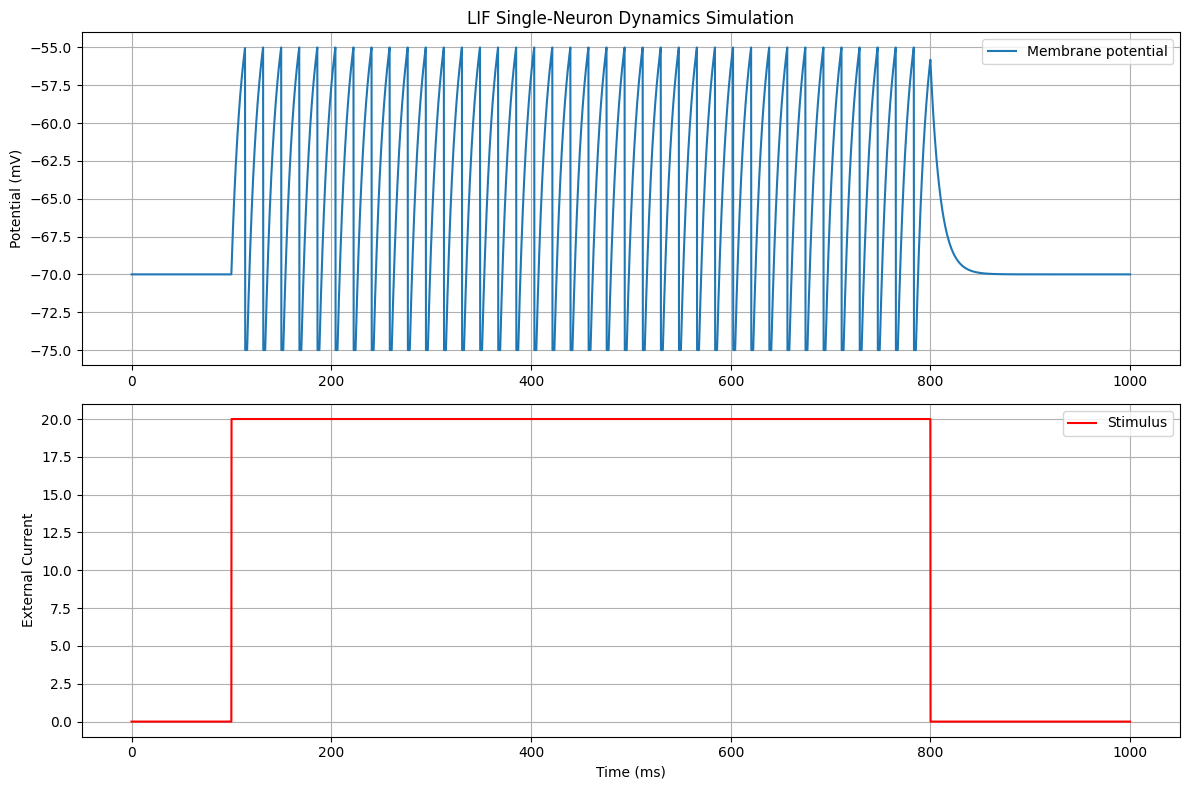

In [61]:
import numpy as np
from matplotlib import pyplot as plt

tau_m = 10.0  # Membrane time constant (ms)
R_m = 1.0  # Resistance (MΩ)
V_reset = -75.0  # Reset potential (mV)
V_th_base = -55.0  # Spike threshold (mV)
V_rest = -70.0  # Resting potential (mV)
t_ref = 2  # Refractory period (ms)


def dVm_dt(V, I_ext):
    return (-(V - V_rest) + R_m * I_ext) / tau_m


def simulate_lif(sim_time, dt, I_ext):
    steps = int(sim_time / dt)

    if len(I_ext) != steps:
        raise ValueError(f"I_ext_arr must have length equal to sim_time / dt ({steps})")

    V_m = V_rest
    refrac_counter = 0

    # Store traces for later plotting
    Vm_trace = np.zeros(steps)

    Vm_trace[0] = V_m

    # --- Simulation Loop (Forward Euler Method) ---
    for i in range(1, steps):
        current_Vm = Vm_trace[i - 1]
        current_I_ext = I_ext[i]

        dVm = dVm_dt(current_Vm, current_I_ext)

        updated_Vm = current_Vm
        if refrac_counter == 0:
            updated_Vm = current_Vm + dVm * dt
        else:
            refrac_counter -= 1

        if updated_Vm >= V_th_base:
            updated_Vm = V_reset
            refrac_counter = int(t_ref / dt)
            # In theory we should keep a list of spike times since they are all-or-nothing events here, but not necessary for visualization

        Vm_trace[i] = updated_Vm

    return Vm_trace


def plot_lif(sim_time, dt, vm_hist, I_ext):
    time_arr = np.arange(0, sim_time, dt)
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_arr, vm_hist, label='Membrane potential')
    plt.ylabel("Potential (mV)")
    plt.title("LIF Single-Neuron Dynamics Simulation")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(time_arr, I_ext, 'r-', label='Stimulus')
    plt.ylabel("External Current")
    plt.xlabel("Time (ms)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    sim_duration = 1000.0  # Total simulation time (ms)
    time_step = 0.1  # Time step (ms) Still Euler but since this isn't a stiff system like HH it is not as sensitive
    num_steps = int(sim_duration / time_step)

    ext_current = np.zeros(num_steps)

    # Example 1: A constant current
    pulse_start_time = 100.0
    pulse_end_time = 800.0
    pulse_amplitude = 20.0  # uA/cm^2

    pulse_start_step = int(pulse_start_time / time_step)
    pulse_end_step = int(pulse_end_time / time_step)
    ext_current[pulse_start_step:pulse_end_step] = pulse_amplitude

    # Run & plot
    voltage_trace = simulate_lif(sim_duration, time_step, ext_current)
    plot_lif(sim_duration, time_step, voltage_trace, ext_current)


Now it's your turn to implement the simplified adaption mechanism!

Use the modified copy of the LIF setup below to implement (`TODO`s) and plot the result.

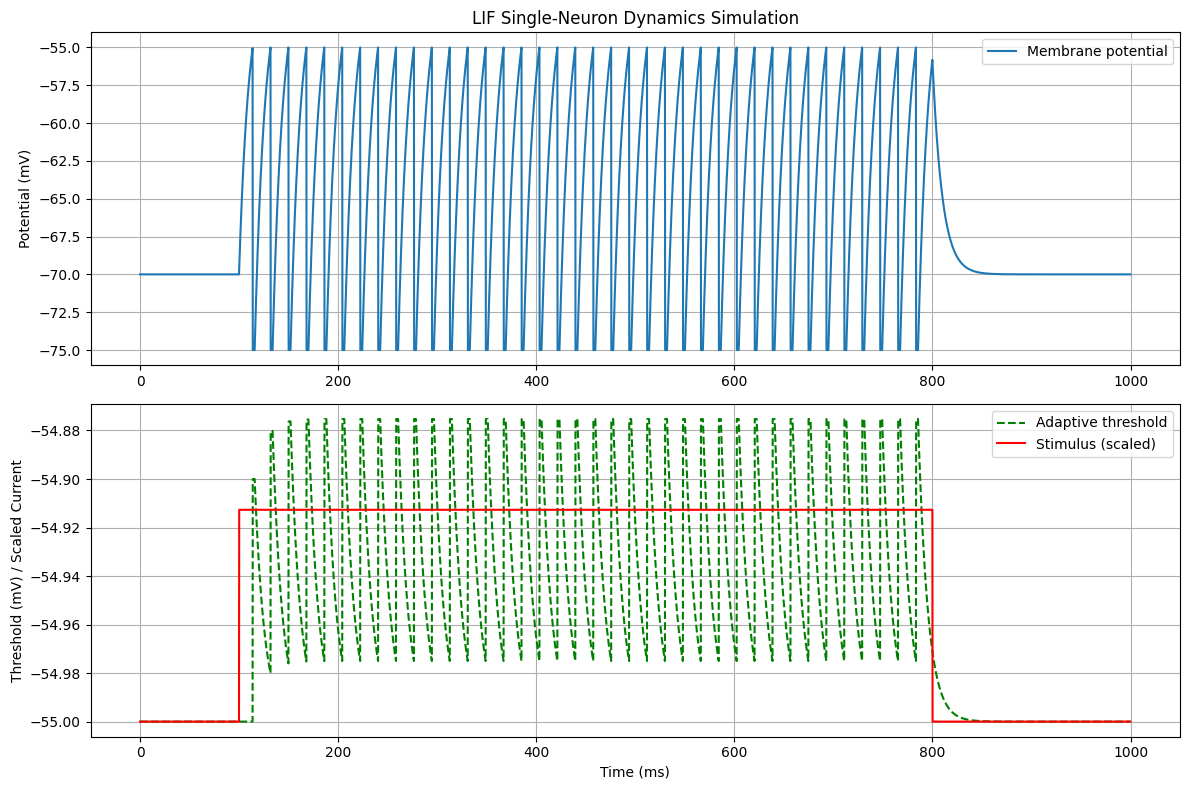

In [71]:
import numpy as np
from matplotlib import pyplot as plt

tau_m = 10.0  # Membrane time constant (ms)
R_m = 1.0  # Resistance (MΩ)
V_reset = -75.0  # Reset potential (mV)
V_th_base = -55.0  # Spike threshold (mV)
V_rest = -70.0  # Resting potential (mV)
t_ref = 2  # Refractory period (ms)

# TODO: tau_th, V_th_inc (choose high values for easier visualization)
tau_th = 10.0
V_th_inc = 0.1

def dVm_dt(V, I_ext):
    return (-(V - V_rest) + R_m * I_ext) / tau_m


def dVth_dt(V_th):
    # TODO: Implement
    return (-(V_th - V_th_base)) / tau_th


def simulate_lif(sim_time, dt, I_ext):
    steps = int(sim_time / dt)

    if len(I_ext) != steps:
        raise ValueError(f"I_ext_arr must have length equal to sim_time / dt ({steps})")

    V_m = V_rest
    refrac_counter = 0
    V_th = V_th_base

    # Store traces for later plotting
    Vm_trace = np.zeros(steps)
    Vth_trace = np.zeros(steps)

    Vm_trace[0] = V_m
    Vth_trace[0] = V_th

    # --- Simulation Loop (Forward Euler Method) ---
    # TODO: Progress dVth in traces, increment
    for i in range(1, steps):
        current_Vm = Vm_trace[i - 1]
        current_Vth = Vth_trace[i - 1]
        current_I_ext = I_ext[i]

        dVm = dVm_dt(current_Vm, current_I_ext)
        dVth = dVth_dt(current_Vth)


        updated_Vm = current_Vm
        updated_Vth = current_Vth

        if refrac_counter == 0:
            updated_Vm = current_Vm + dVm * dt
            updated_Vth = current_Vth + dVth * dt # increment
        else:
            refrac_counter -= 1

        if updated_Vm >= updated_Vth:
            updated_Vm = V_reset
            refrac_counter = int(t_ref / dt)
            updated_Vth += V_th_inc
            # In theory we should keep a list of spike times since they are all-or-nothing events here, but not necessary for visualization

        Vth_trace[i] = updated_Vth
        Vm_trace[i] = updated_Vm

    return Vm_trace, Vth_trace


def plot_lif(sim_time, dt, vm_hist, vth_hist, I_ext):
    time_arr = np.arange(0, sim_time, dt)
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_arr, vm_hist, label='Membrane potential')
    plt.ylabel("Potential (mV)")
    plt.title("LIF Single-Neuron Dynamics Simulation")
    plt.grid(True)
    plt.legend()

    # Plot threshold and scaled current together
    plt.subplot(2, 1, 2)
    plt.plot(time_arr, vth_hist, 'g--', label='Adaptive threshold')

    current_scale_factor = (np.max(vth_hist) - np.min(vth_hist)) / (np.max(I_ext) if np.max(I_ext) > 0 else 1)
    scaled_current = np.min(vth_hist) + I_ext * current_scale_factor * 0.7

    plt.plot(time_arr, scaled_current, 'r-', label='Stimulus (scaled)')
    plt.ylabel("Threshold (mV) / Scaled Current")
    plt.xlabel("Time (ms)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    sim_duration = 1000.0  # Total simulation time (ms)
    time_step = 0.1  # Time step (ms) Still Euler but since this isn't a stiff system like HH it is not as sensitive
    num_steps = int(sim_duration / time_step)

    ext_current = np.zeros(num_steps)

    # Example 1: A constant current
    pulse_start_time = 100.0
    pulse_end_time = 800.0
    pulse_amplitude = 20.0  # uA/cm^2

    pulse_start_step = int(pulse_start_time / time_step)
    pulse_end_step = int(pulse_end_time / time_step)
    ext_current[pulse_start_step:pulse_end_step] = pulse_amplitude

    # Run & plot
    voltage_trace, threshold_trace = simulate_lif(sim_duration, time_step, ext_current)
    plot_lif(sim_duration, time_step, voltage_trace, threshold_trace, ext_current)


## **Part 2.** Training Biologically Plausible Networks (4 points)
Back to machine learning we go! Let's first setup CUDA and imports:

In [72]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import math
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import string
torch.manual_seed(42)
import random

if torch.cuda.is_available():
  print('Set device to CUDA.')
  device = torch.device('cuda')
else:
  print('Warning: Running on CPUs, which will slow down the computations.')
  device = torch.device("cpu")

Set device to CUDA.


### 2.1 Recurrent Neural Networks

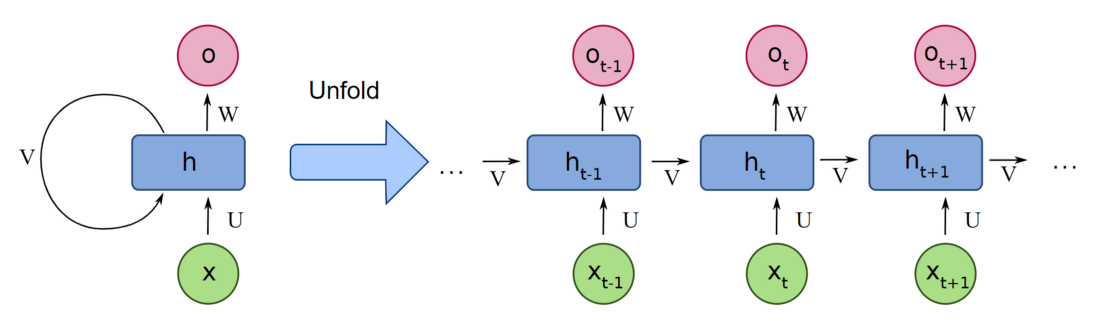

### Exercise 2.1: Implementing a simple RNN (2 points)

Let's start with a simple recurrent network. As we just introduced, let
$$
\begin{align}
\mathbf{h}_t&=\tanh(W_{ih}\mathbf{x}_t+W_{hh}\mathbf{h}_{t-1})\\
\mathbf{o}_t&=W_{o}\mathbf{h}_t
\end{align}
$$
for $t=1,\ldots,T$ where $\mathbf{h}_0=\mathbf{0}$.
You learned about "unfolding": during training, the whole sequence $\mathbf{x}_1,\ldots,\mathbf{x}_T$ is known. Most importantly, all time steps **share the same** $W_{ih}$ **and** $W_{hh}$.

Implement the following scaffolding for a simple RNN.
The `RNNCell` is an `nn.Module` that receives a batch of inputs ($\mathbf{x}_t$) `(batch_size, input_dim)` and a hidden state ($\mathbf{h}_{t-1}$) `(batch_size, hidden_dim)`, and outputs a tuple ($\mathbf{o}_t$), ($\mathbf{h}_t$), of shape `(batch_size, output_dim)` and `(batch_size, output_dim)` respectively (i.e. batched).
Initialize the weights using `xavier_uniform`.

The `SimpleRNN` takes care of the unfolding: it receives a batch of sequences $\mathbf{x}_1,\ldots,\mathbf{x}_T$ in the shape `(batch_size, time, dim)` and outputs a tuple `(outputs, hidden)`, of shape `(batch_size, time, output_dim)` and `(batch_size, time, hidden_dim)` respectively (i.e. batched).
Make sure to create an initial hidden state, don't forget to put it on the current `device`.


`TODO`s in the cells below (1 point)


In [ ]:
class RNNCell(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super(RNNCell, self).__init__()

        # TODO initialise tensors
        self.w_ii = ...
        self.w_hh = ...
        self.w_o = ...

        torch.nn.init.xavier_uniform_(self.w_ii)
        torch.nn.init.xavier_uniform_(self.w_hh)
        torch.nn.init.xavier_uniform_(self.w_o)

    def forward(self, x_t: torch.Tensor, h_prev: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # TODO forward pass
        h_t = ...
        o_t = ...
        return o_t, h_t



class SimpleRNN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.rnn_cell = RNNCell(input_dim, hidden_dim, output_dim)

    def forward(self, xs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Shapes:
          xs: (batch, time, input_dim)
          outputs: (batch, time, output_dim)
          hiddens: (batch, time, hidden_dim)
        """
        # TODO initialise tensor
        h_t = ...
        hiddens = []
        outputs = []

        for t in range(xs.shape[1]):
            o_t, h_t = self.rnn_cell(xs[:, t, :], h_t)
            hiddens.append(h_t)
            outputs.append(o_t)

        hiddens = torch.stack(hiddens, dim=1)
        outputs = torch.stack(outputs, dim=1)

        return outputs, hiddens

Now, we can start training the network on predicting the points on a sine function, i.e. given $\sin(t-N\cdot\Delta),\ldots,\sin(t-\Delta),\sin(t)$, what is $\sin(t+\Delta)$?

Our training data would look like:

In [ ]:
t_delta = 0.1
num_timesteps = 10
num_examples = 100

examples = []
for _ in range(num_examples):
  starting_point = torch.randn((1,))
  examples.append(torch.sin(starting_point + torch.arange(0, num_timesteps, t_delta)))

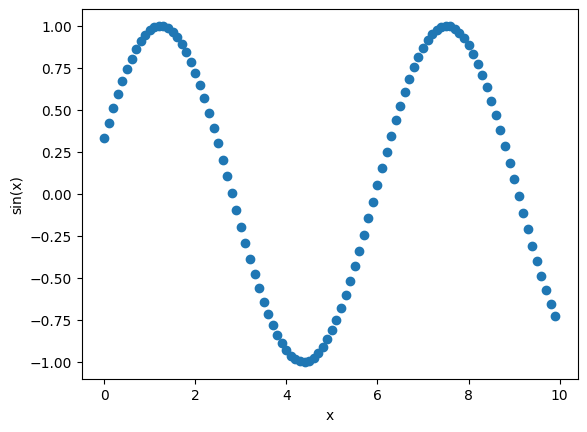

In [ ]:
plt.scatter(torch.arange(0, num_timesteps, t_delta), examples[0])
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.show()

We then train the network. **Implement** the loss function as the mean-squared error loss between the network prediction for time step $t$ and the ground-truth at time step $t$.

In [ ]:
input_dim = 1
hidden_dim = 32
output_dim = 1
batch_size = 64

num_steps = len(examples) * 5
learning_rate = 0.02

model = SimpleRNN(input_dim, hidden_dim, output_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
losses = []

progressbar = tqdm(range(num_steps), desc=f'Step [0/{num_steps}], Loss: ---')
for steps in progressbar:
    optimizer.zero_grad()
    sequence_batch = random.choices(examples, k=batch_size)
    sequence_batch = torch.stack(sequence_batch).unsqueeze(-1).detach().to(device)
    # shape: (batch, time, 1)

    preds, _ = model(sequence_batch)

    # TODO: https://docs.pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
    #loss = torch.nn.functional.mse_loss(..., ...)
    loss = ...
    # END TODO
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().item())
    progressbar.set_description(f'Step [{steps+1}/{num_steps}], Loss: {loss.detach().item():.5f}')

AttributeError: 'ellipsis' object has no attribute 'dim'

Plot the loss history:

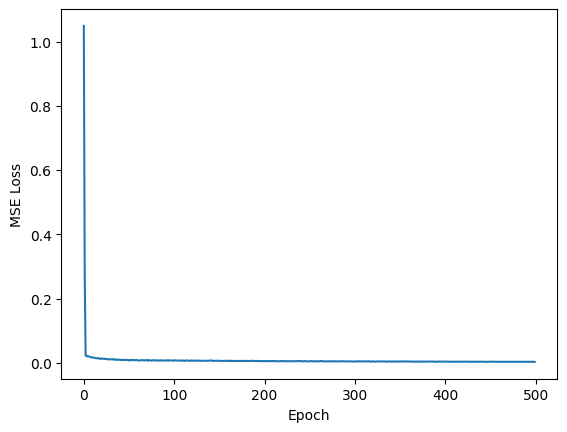

In [ ]:
# Plotting the training loss
plt.plot(torch.arange(0, len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

Judging by the rapid convergence, this appears to be an easy task for our RNN. Let's plot the predicted curve starting at an arbitrary value:

In [ ]:
starting_value = math.sin(0.2)

with torch.inference_mode():
  current_sequence = [starting_value]
  print(f"{current_sequence[0]:.3f}", end="")

  for _ in range(100):
    outs, _ = model(torch.tensor(current_sequence, device=device).view(1, len(current_sequence), 1))
    next_val = outs[0, -1, 0]
    current_sequence.append(next_val.item())
    print(f" {next_val:.3f}", end="")

0.199 0.083 0.161 0.246 0.169 0.239 0.297 0.233 0.271 0.319 0.263 0.272 0.298 0.255 0.227 0.217 0.162 0.120 0.077 0.001 -0.060 -0.113 -0.196 -0.276 -0.337 -0.409 -0.486 -0.553 -0.616 -0.672 -0.722 -0.770 -0.802 -0.819 -0.832 -0.836 -0.823 -0.800 -0.769 -0.728 -0.677 -0.614 -0.540 -0.458 -0.367 -0.267 -0.162 -0.057 0.047 0.148 0.244 0.334 0.419 0.501 0.580 0.655 0.726 0.791 0.849 0.897 0.935 0.961 0.976 0.981 0.976 0.962 0.941 0.912 0.875 0.831 0.780 0.720 0.651 0.573 0.486 0.390 0.287 0.179 0.070 -0.037 -0.140 -0.237 -0.328 -0.415 -0.497 -0.576 -0.651 -0.723 -0.789 -0.848 -0.897 -0.936 -0.964 -0.980 -0.986 -0.982 -0.969 -0.949 -0.921 -0.885 -0.843

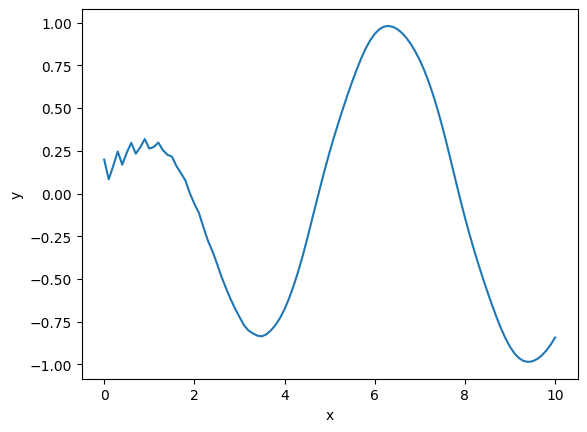

In [ ]:
plt.plot(torch.arange(0, len(current_sequence)) * t_delta, current_sequence, label="approx.")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Beautiful!

**Question (1 point)**: Intuitively, why do you think we see the small zig-zag lines at the start of the prediction interval? Feel free to comment your answer below in this cell.

### 2.2 Surrogate Gradient Descent and Spiking Neural Networks

#### Preparing the dataset
First of all, run the next cell to download the [Spiking Heidelberg Digits ](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/) dataset (the following tutorial is partially adapted from Friedemann Zenke). This sometimes fails, just re-run the cell in that case.

The spikes are generated by recording people saying digits from zero to nine in English and German, applying a model of a biological inner ear.

In [ ]:
import os
import urllib.request
import gzip, shutil
import hashlib

from six.moves.urllib.error import HTTPError
from six.moves.urllib.error import URLError
from six.moves.urllib.request import urlretrieve

def validate_file(fpath, file_hash, algorithm='auto', chunk_size=65535):
    if (algorithm == 'sha256') or (algorithm == 'auto' and len(file_hash) == 64):
        hasher = 'sha256'
    else:
        hasher = 'md5'

    if str(_hash_file(fpath, hasher, chunk_size)) == str(file_hash):
        return True
    else:
        return False

def _hash_file(fpath, algorithm='sha256', chunk_size=65535):
    if (algorithm == 'sha256') or (algorithm == 'auto' and len(hash) == 64):
        hasher = hashlib.sha256()
    else:
        hasher = hashlib.md5()

    with open(fpath, 'rb') as fpath_file:
        for chunk in iter(lambda: fpath_file.read(chunk_size), b''):
            hasher.update(chunk)

    return hasher.hexdigest()

def get_file(fname,
             origin,
             md5_hash=None,
             file_hash=None,
             cache_subdir='datasets',
             hash_algorithm='auto',
             extract=False,
             archive_format='auto',
             cache_dir=None):
    if cache_dir is None:
        cache_dir = os.path.join(os.path.expanduser('~'), '.data-cache')
    if md5_hash is not None and file_hash is None:
        file_hash = md5_hash
        hash_algorithm = 'md5'
    datadir_base = os.path.expanduser(cache_dir)
    if not os.access(datadir_base, os.W_OK):
        datadir_base = os.path.join('/tmp', '.data-cache')
    datadir = os.path.join(datadir_base, cache_subdir)

    # Create directories if they don't exist
    os.makedirs(cache_dir, exist_ok=True)
    os.makedirs(datadir, exist_ok=True)

    fpath = os.path.join(datadir, fname)

    download = False
    if os.path.exists(fpath):
    # File found; verify integrity if a hash was provided.
        if file_hash is not None:
            if not validate_file(fpath, file_hash, algorithm=hash_algorithm):
                print('A local file was found, but it seems to be '
                      'incomplete or outdated because the ' + hash_algorithm +
                      ' file hash does not match the original value of ' + file_hash +
                      ' so we will re-download the data.')
                download = True
    else:
        download = True

    if download:
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)

    return fpath


def get_and_gunzip(origin, filename, md5hash=None, cache_dir=None, cache_subdir=None):
    gz_file_path = get_file(filename, origin, md5_hash=md5hash, cache_dir=cache_dir, cache_subdir=cache_subdir)
    hdf5_file_path = gz_file_path[:-3]
    if not os.path.isfile(hdf5_file_path) or os.path.getctime(gz_file_path) > os.path.getctime(hdf5_file_path):
        print("Decompressing %s"%gz_file_path)
        with gzip.open(gz_file_path, 'r') as f_in, open(hdf5_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    return hdf5_file_path


def get_shd_dataset(cache_dir, cache_subdir):

    # The remote directory with the data files
    base_url = "https://zenkelab.org/datasets"

    # Retrieve MD5 hashes from remote
    response = urllib.request.urlopen("%s/md5sums.txt"%base_url)
    data = response.read()
    lines = data.decode('utf-8').split("\n")
    file_hashes = { line.split()[1]:line.split()[0] for line in lines if len(line.split())==2 }

    # Download the Spiking Heidelberg Digits (SHD) dataset
    files = [ "shd_train.h5.gz",
              "shd_test.h5.gz",
            ]
    for fn in files:
        origin = "%s/%s"%(base_url,fn)
        hdf5_file_path = get_and_gunzip(origin, fn, md5hash=file_hashes[fn], cache_dir=cache_dir, cache_subdir=cache_subdir)
        # print("File %s decompressed to:"%(fn))
        print("Available at: %s"%hdf5_file_path)


import h5py

cache_dir = os.path.expanduser("~/data")
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

train_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_train.h5'), 'r')
test_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_test.h5'), 'r')

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']

Decompressing /root/data/hdspikes/shd_train.h5.gz
Available at: /root/data/hdspikes/shd_train.h5
Available at: /root/data/hdspikes/shd_test.h5


We now have the exact times at which the neurons spike.

(4278,) (4278,)


Text(0, 0.5, 'neuron')

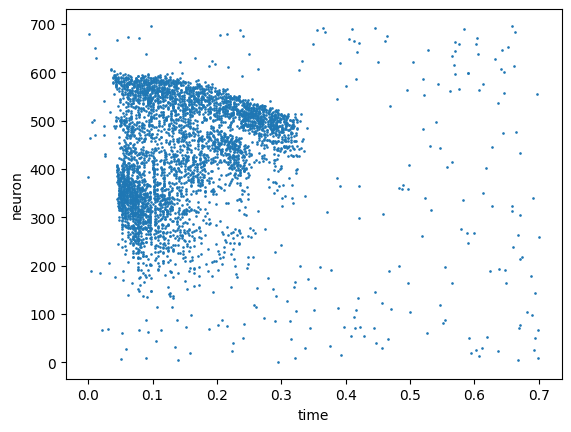

In [ ]:
# when presented sample 0, neuron 384 fires at time 0, neuron 680 fires at time 0.001833, ...
print(x_train['times'][0].shape, x_train["units"][0].shape)

plt.scatter(x_train['times'][0], x_train["units"][0], s=0.8)
plt.xlabel("time")
plt.ylabel("neuron")

However, we need to **discretize**, which means that we split (i.e. bin) a fixed time interval `[0, max_time]` into `nb_steps`.

In [ ]:
nb_inputs  = 700
nb_hidden  = 200
nb_outputs = 20

time_step = 1e-3
nb_steps = 100
max_time = 1.4

batch_size = 256
# batch_size = 16  # adapt if necessary

def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    """ This generator takes a spike dataset and generates spiking network input as sparse tensors.

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time, neuron) tuples
        y: The labels
    """

    labels_ = np.array(y, dtype=np.int32)
    number_of_batches = len(labels_) // batch_size
    sample_index = np.arange(len(labels_))

    # compute discrete firing times
    firing_times = X['times']
    units_fired = X['units']

    # splitting the interval into nb_steps
    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter < number_of_batches:
        batch_index = sample_index[batch_size * counter : batch_size * (counter + 1)]

        # Stores spikes in the sparse COO format (ignore this for now)
        coo = [ [] for i in range(3) ]
        for bc, idx in enumerate(batch_index):
            times = np.digitize(firing_times[idx], time_bins)  # digitize gets the "bin index" of a firing time
            units = units_fired[idx]
            batch = [bc for _ in range(len(times))]

            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)
            # equivalent to X[batch, 0] = times; X[batch, 1] = units for dense matrices

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)

        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size, nb_steps, nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)
        # What we get here is an X_batch (batch, 2) and a Y_batch (batch, )

        counter += 1

#### Building the a LIF-based SNN
Now, let's build an SNN with leaky integrate-and-fire neurons.

**Note**: LIF neuron rarely equals LIF neuron! There are many popular implementations out there and while they all share the same principle but the exact details of how a reset is implemented, what constitutes the input etc. can vary - especially when coming from implementations written for neuroscience simulation (first part of this exercise).


We define

$$
\begin{align}
\alpha &= e^{-\Delta t/\tau_{\rm syn}}\\
\beta &= e^{-\Delta t/\tau_{\rm mem}}\\
I_{\rm syn}[t+1]&=\underbrace{\alpha I_{\rm syn}[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input}\\
U[t+1] &= \underbrace{\beta U[t]}_\text{decay} + \underbrace{I_{\rm syn}[t+1]}_\text{input} - \underbrace{R[t]}_\text{reset}\\
R[t] &= \beta \cdot S[t]\cdot\theta\\
S[t+1] &= H(U[t+1]-\theta)
\end{align}
$$

Observe that we model a **second-order** LIF here: the synaptic current is recurrent as well. In a first-order LIF, $I_{syn}[t+1]=WX[t+1]$ (or $\alpha=0$).

Implement this below. Analogously to the non-spiking RNNCell, the output should be the spike $s_{t+1}$ ("output"), the membrane potential $u_{t+1}$ and the synaptic current $v_{t+1}$ ("states").

Here, $U$ is the membrane potential with decay factor $\beta$.
$W$ is the input projection

In [ ]:
class LIF(nn.Module):
    def __init__(self, input_dim: int, state_dim: int, alpha: float = 0.9, beta: float = 0.9, threshold: float = 1.0, spike_fn = None):
        super(LIF, self).__init__()

        self.alpha = alpha
        self.beta = beta
        self.threshold = threshold
        self.W = torch.nn.Parameter(torch.empty(input_dim, state_dim))
        torch.nn.init.normal_(self.W, mean=0.0, std=0.2 / np.sqrt(input_dim))

        self.spike_fn = (lambda x: (x > 0).float()) if spike_fn is None else spike_fn


    def forward(self, x: torch.Tensor, u: torch.Tensor, i_syn: torch.Tensor, prev_spike: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Let's check if we spike with our current membrane potential
        # TODO
        s_t = self.spike_fn(u- self.threshold)

        # TODO. Stop gradient backpropagation through S[T] via .detach() on the tensor part
        r_t = self.beta * s_t.detach() * self.threshold

        # TODO: u_{t+1}
        u_next = self.beta* u+ i_syn - r_t

        # TODO: Isyn[t+1]
        i_next = self.alpha * i_syn + x @ self.W
        return s_t, u_next, i_next

Alright, let's train it to spike, i.e. to output 1.

In [ ]:
lif = LIF(1, 2)
lif.to(device)
x, u, i, s = torch.zeros((1,), device=device), torch.randn((2,), device=device), torch.randn((2,), device=device), torch.zeros((2,), device=device)

for t in range(10):
  s, u, i = lif(x, u, i, s)

loss = torch.nn.functional.mse_loss(s, torch.tensor(1, device=device))
loss.backward()

<ipython-input-12-d8f13313c764>:8: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(s, torch.tensor(1, device=device))


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Uh oh! Well unsurprisingly, we cannot differentiate through the discrete step function. Therefore, we must manually define the backward pass for our step function.

Recall the backpropagation rule for $W$ from the first week
$$
\frac{\partial L}{\partial W_{ij}} = \frac{\partial L}{\partial s_j} \cdot H'(a_j) \cdot a_j.
$$
where now $a_j$ is the input to `spike_fn`. Clearly, $H'$ is the issue.

Looking [into the ancient papers](https://www.biorxiv.org/content/10.1101/2020.06.29.176925v1.full.pdf), we see a replacement for $H'$ with a cool name: the **SuperSpike** (Zenke & Ganguli, 2018), which is defined as

$$H'(x) = \frac{1}{(\beta|x|+1)^2}.$$
Let's implement our first custom PyTorch function by defining **both** its forward and backward passes.

In [ ]:
class SuperSpikeHeaviside(torch.autograd.Function):
    beta = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        # Store "locally available quantities" that will be available during backward
        # Here, we store the input to this function.
        ctx.save_for_backward(input)

        # TODO: Compute the forward pass of the Heaviside step function
        # For each element of input, return 1.0 if it's positive.
        out = (input > 0).float()

        return out

    @staticmethod
    def backward(ctx, grad_output):
        # Load the quantities saved above. Note that it's a tuple, hence the notation!
        input, = ctx.saved_tensors

        # You will probably need this.
        grad_input = grad_output.clone()

        # Some Python lore: note that these functions are defined with @staticmethod.
        # Therefore, they exist "statically", i.e. without having to run `var = SurrGradSpike()`.
        # So, as we define beta in the class itself, it becomes a class variable, which we access via class_name.var, hence:
        beta = SuperSpikeHeaviside.beta

        # TODO: implement
        grad = grad_input / np.square(beta*np.abs(input)+1) * input
        return grad


In [ ]:
super_lif = LIF(1, 2, spike_fn=SuperSpikeHeaviside.apply)
super_lif.to(device)

# Let's quickly test if this allows us to backprop now:
x, u, i, s = torch.zeros((1,), device=device), torch.randn((2,), device=device), torch.randn((2,), device=device), torch.zeros((2,), device=device)
for t in range(10):
  s, u, i = super_lif(x, u, i, s)

loss = torch.nn.functional.mse_loss(s, torch.tensor(1., device=device))
loss.backward()

<ipython-input-14-280769f42455>:9: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(s, torch.tensor(1., device=device))


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

And we have a gradient. Let's put everything together and learn to listen to digits!

In [ ]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))


class SpikingReadout(nn.Module):
  def __init__(self, input_dim: int, num_classes: int, alpha: int, beta: int):
    super().__init__()

    self.W = torch.nn.Parameter(torch.empty(input_dim, num_classes))
    torch.nn.init.normal_(self.W, mean=0.0, std=0.2 / np.sqrt(input_dim))
    self.alpha = alpha
    self.beta = beta

  def forward(self, x, u, i):
    # leaky-integrate without fire
    new_i = self.alpha * i + x @ self.W
    new_u = self.beta * u + new_i

    return new_u, new_i

class DeepSNN(nn.Module):
  def __init__(self):
    super().__init__()

    # Initialize layers
    self.lif1 = LIF(nb_inputs, nb_hidden, alpha=alpha, beta=beta, spike_fn=SuperSpikeHeaviside.apply)
    self.readout = SpikingReadout(nb_hidden, nb_outputs, alpha=alpha, beta=beta,)

  def forward(self, x):
    """
    Shapes:
      x: (batch, time, nb_inputs)

    Returns:
      tuple (potentials, hidden_spikes)
        potentials: (batch, time, nb_outputs)
        hidden_spikes: (batch, time, nb_hidden)
    """
    # TODO: implement the initial states of each layer.
    u1 = torch.zeros((x.shape[0], nb_hidden), device= device)
    u2 = torch.zeros((x.shape[0], nb_outputs), device= device)
    i1 = torch.zeros((x.shape[0], nb_hidden), device= device)
    i2 = torch.zeros((x.shape[0], nb_outputs), device= device)
    s1 = torch.zeros((x.shape[0], nb_outputs), device= device)

    final_potentials = []
    hidden_spikes = []
    for t in range(nb_steps):
      # TODO implement
      ...
      s1, u1, i1 = ...
      u2, i2 = ...

      # END TODO
      hidden_spikes.append(s1)
      final_potentials.append(u2)

    return torch.stack(final_potentials, dim=1), torch.stack(hidden_spikes, dim=1)

snn = DeepSNN().to(device)

Let's train! We apply regularization loss to both the total number of spikes (L1) and the average squared sum across batch and time dimension (L2). This serves to encourage both a sparser network in general and a larger variety of neurons contributing, which should make the network more robust to noise and allow for better generalization.

In [ ]:
def train(x_data, y_data, lr=1e-3, nb_epochs=10):
    optimizer = torch.optim.Adamax(snn.parameters(), lr=lr, betas=(0.9, 0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in (pbar := tqdm(
              sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time),
              total=len(y_data) // batch_size
            )):
            x = x_local.to_dense()
            out_spikes, hidden_spikes = snn(x)
            # we have a neuron per class
            # the neuron spiking the most predicts the class
            m, _ = torch.max(out_spikes, 1)
            log_p_y = log_softmax_fn(m)

            reg_loss = 2e-6 * torch.sum(hidden_spikes) # L1 loss on total number of spikes
            reg_loss += 2e-6 * torch.mean(torch.sum(torch.sum(hidden_spikes, dim=0), dim=0)**2) # L2 loss on spikes per neuron

            # Here we combine supervised loss and the regularizer
            loss_val = loss_fn(log_p_y, y_local.long()) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
            pbar.set_description(f'Epoch [{e+1}/{nb_epochs}], Loss: {loss_val.item():.5f}')
        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)

    return loss_hist

In [ ]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=3)  # should be 200 epochs for better perf. but this suffices for now...

  0%|          | 0/31 [00:00<?, ?it/s]<ipython-input-16-ad3aa91a7fb6>:54: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)
  X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size, nb_steps, nb_units])).to(device)
Epoch [3/3], Loss: 2.79451: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


In [ ]:
@torch.inference_mode()
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time, shuffle=False):
        spikes, _ = snn(x_local.to_dense())
        m, _= torch.max(spikes, 1) # max over time
        _, am = torch.max(m, 1)      # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs) * 100
test_acc = compute_classification_accuracy(x_test, y_test)
print(f"Test accuracy: {test_acc:.2f}%")

tensor(16, device='cuda:0') tensor(10, device='cuda:0', dtype=torch.int32)
tensor(13, device='cuda:0') tensor(13, device='cuda:0', dtype=torch.int32)
tensor(17, device='cuda:0') tensor(17, device='cuda:0', dtype=torch.int32)
tensor(0, device='cuda:0') tensor(4, device='cuda:0', dtype=torch.int32)
tensor(0, device='cuda:0') tensor(10, device='cuda:0', dtype=torch.int32)
tensor(17, device='cuda:0') tensor(10, device='cuda:0', dtype=torch.int32)
tensor(0, device='cuda:0') tensor(4, device='cuda:0', dtype=torch.int32)
tensor(0, device='cuda:0') tensor(15, device='cuda:0', dtype=torch.int32)
Test accuracy: 15.28%


Given the small amount of epochs we ran this demo for, that's something! Feel free to try and increase the iterations to see convergence.

### Exercise 2.2: Feedback Alignment (2 points)
Let's first assume a three layer MLP of linear layers
$$\mathbf{y}^{(l)}= \sigma((\mathbf{w}^{(l)})^T\mathbf{x}^{(l-1)})$$
for layers $l=1,2,3$ and $x^{(0)}$ is the input and we optimize it on any loss function $\mathcal{L}$.

In the next lecture, you will learn about the three factor learning rule with backpropagation as a variant of such a rule:
$$
\nabla \mathbf{W}^{(l)} \propto -\underbrace{\mathbf{e}^{(l+1)}}_\text{ modulat.}\underbrace{\mathbf{y}^{(l)}}_\text{post-syn.}\underbrace{(\mathbf{w}^{(l)})^T\mathbf{x}^{(l-1)}}_\text{pre-syn.}.
$$
In the brain, this term would have to be computed by some feedback neuron.
While $\mathbf{e}$, $\mathbf{y}$ and $\mathbf{x}$ could all impinge at such a neuron, there is no physical mechanism for the feedback neuron to know $\mathbf{w}$.

[Lillicrap et al.](https://www.nature.com/articles/ncomms13276) propose a straightforward alternative: what if we replace $\mathbf{w}^T$ with some random, but **fixed** weights $\mathbf{b}$? This is known as **feedback alignment** (FA).

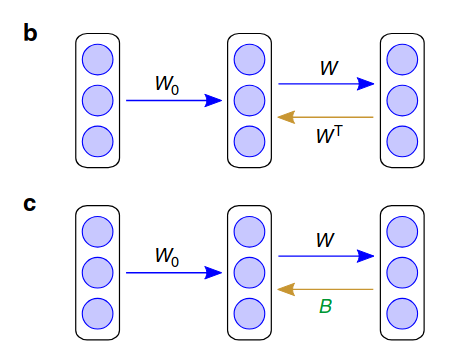

Let's first define a linear FA layer. Your task here is to simply define the random gradient projection $\mathbf{b}$ in `self.weight_fa`.

In [ ]:
class LinearFALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LinearFALayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weight = torch.nn.Parameter(torch.empty(out_dim, in_dim))
        torch.nn.init.kaiming_uniform_(self.weight)

        # TODO
        self.weight_fa = ...
        torch.nn.init.kaiming_uniform_(self.weight_fa)
    def forward(self, x):
        return x @ self.weight.T

However, we now have to tell PyTorch's autograd to compute the weights differently. This means defining a `torch.autograd.Function` as we did in the lecture: This will be your task:

In [ ]:
from torch.autograd import Function

class LinearFAFunction(Function):
    @staticmethod
    def forward(ctx, input, weight, weight_fa):
        # TODO
        ctx.save_for_backward(...)
        output = ...
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # grad_output contains the top-down error e^{(l+1)}

        # Load the above quantities
        input, weight, weight_fa = ctx.saved_variables
        grad_input = grad_weight = grad_weight_fa = None

        # ctx.needs_input_grad now is a (bool, bool, bool) tuple for (input, weight, weight_fa) respectively
        # for the first layer, ctx.needs_input_grad[0] is False, since the input is not updated, but true for all other layers
        # we have to return a gradient for each saved variable

        if ctx.needs_input_grad[0]:
            # TODO: Implement the error passed to the layer below ("input")
            grad_input = ...
        else:
          grad_input = None

        if ctx.needs_input_grad[1]:
          # TODO: assume grad_output contains the top-down error transported via feedback alignment
          grad_weight = ...
        else:
          grad_weight = None

        # TODO: how do we update the feedback alignment weights? DO we update the FA weights?
        grad_weight_fa = ...

        # End of TODO
        return grad_input, grad_weight, grad_weight_fa


You're done now! Run the code below to check if everything works - ideally FA should be close to the original backpropagation loss.

In [ ]:
import torch.nn as nn
from torch.optim import SGD
from torchvision.datasets import USPS
from torchvision.transforms import ToTensor

batch_size = 128
device = "cuda"

ds = USPS("./data", train=True, download=True, transform=ToTensor())
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

test_ds = USPS("./data", train=False, download=True, transform=ToTensor())
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

model_bp = nn.Linear(16 * 16, 10)
model_bp.to(device)

model_fa = LinearFALayer(16 * 16, 10)
model_fa.to(device)

optim_bp = SGD(model_bp.parameters(), lr=0.0001)
optim_fa = SGD(model_fa.parameters(), lr=0.0001)

for epoch in range(20):
  epoch_loss_bp = 0
  epoch_loss_fa = 0
  for batch in dl:
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    # standard bp model
    logits_bp = model_bp(x.view(x.shape[0], -1))
    loss_bp = nn.functional.cross_entropy(logits_bp, y)
    loss_bp.backward()
    optim_bp.step()
    epoch_loss_bp += loss_bp.item()

    # fa_model
    logits_fa = model_fa(x.view(x.shape[0], -1))
    loss_fa = nn.functional.cross_entropy(logits_fa, y)
    loss_fa.backward()
    optim_fa.step()
    epoch_loss_fa += loss_fa.item()

  with torch.inference_mode():
    n_correct_bp = 0
    n_correct_fa = 0
    n_total = 0
    for batch in test_dl:
      x, y = batch
      x = x.to(device)
      y = y.to(device)
      logits_bp = model_bp(x.view(x.shape[0], -1))
      n_correct_bp += (logits_bp.argmax(dim=1) == y).sum()
      logits_fa = model_fa(x.view(x.shape[0], -1))
      n_correct_fa += (logits_fa.argmax(dim=1) == y).sum()
      n_total += x.shape[0]
  print(f"epoch {epoch} (BP): train_loss={epoch_loss_bp / len(dl):.4f}, test_acc={n_correct_bp / n_total * 100:.2f}%")
  print(f"epoch {epoch} (FA): train_loss={epoch_loss_fa / len(dl):.4f}, test_acc={n_correct_fa / n_total * 100:.2f}%")
  print('-')


100%|██████████| 6.58M/6.58M [00:00<00:00, 14.7MB/s]
100%|██████████| 1.83M/1.83M [00:00<00:00, 5.35MB/s]


epoch 0 (BP): train_loss=2.2338, test_acc=35.23%
epoch 0 (FA): train_loss=2.2818, test_acc=29.10%
-
epoch 1 (BP): train_loss=2.0004, test_acc=31.54%
epoch 1 (FA): train_loss=2.0221, test_acc=32.09%
-
epoch 2 (BP): train_loss=1.7231, test_acc=45.29%
epoch 2 (FA): train_loss=1.7451, test_acc=46.64%
-
epoch 3 (BP): train_loss=1.3574, test_acc=69.06%
epoch 3 (FA): train_loss=1.4203, test_acc=62.18%
-
epoch 4 (BP): train_loss=1.0463, test_acc=75.54%
epoch 4 (FA): train_loss=1.1243, test_acc=69.46%
-
epoch 5 (BP): train_loss=0.8391, test_acc=78.92%
epoch 5 (FA): train_loss=0.8845, test_acc=76.73%
-
epoch 6 (BP): train_loss=0.6771, test_acc=82.01%
epoch 6 (FA): train_loss=0.6870, test_acc=81.07%
-
epoch 7 (BP): train_loss=0.5566, test_acc=83.26%
epoch 7 (FA): train_loss=0.5626, test_acc=82.36%
-
epoch 8 (BP): train_loss=0.4717, test_acc=84.26%
epoch 8 (FA): train_loss=0.5005, test_acc=81.96%
-
epoch 9 (BP): train_loss=0.4194, test_acc=84.40%
epoch 9 (FA): train_loss=0.4698, test_acc=82.06%
-
